In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
from os import sep
from scipy import sparse;
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import string
import re
from nltk.stem.porter import PorterStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.corpus import wordnet

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('./drive/MyDrive/ml_detail.csv', sep=',', encoding='latin-1')

In [ ]:
df.head()

,movie id,user id,rating,content,date,movie index,user index
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81


In [ ]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)


In [ ]:
df["content"] = df["content"].apply(lambda text: remove_html(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81


In [ ]:
df["text_lower"] = df["content"].str.lower()
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ..."
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...


In [ ]:
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replace_contraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text


In [ ]:
df["text_contraction_extract"] = df["text_lower"].apply(lambda text: replace_contraction(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ..."
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...


In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


In [ ]:
df["text_wo_punct"] = df["text_contraction_extract"].apply(lambda text: remove_punctuation(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...


In [ ]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 5.3 MB/s 


In [ ]:

from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
#df["text_correct_spellings"] = df["text_wo_punct"].apply(lambda text: correct_spellings(text))

In [ ]:
def replace(word, pos=None):
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name())
    if len(antonyms) == 1:
        return antonyms.pop()
    else:
        return None
def replaceNegations(text):
    i, l = 0, len(text)
    words = []
    while i < l:
        word = text[i]
        if word == 'not' and i+1 < l:
            ant = replace(text[i+1])
            if ant:
                words.append(ant)
                i += 2
                continue
        words.append(word)
        i += 1
    return words
def negation_preprocess(text):
  res = " ".join(replaceNegations(text.split(" ")))
  return res

In [ ]:
df["text_negation_preprocess"] = df["text_wo_punct"].apply(lambda text: negation_preprocess(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...


In [ ]:
from collections import Counter
cnt = Counter()
for text in df['text_negation_preprocess'].values:
  for word in text.split():
    cnt[word] += 1
cnt.most_common(20)

[('the', 1337646),
 ('and', 744091),
 ('is', 730143),
 ('a', 696198),
 ('of', 582329),
 ('to', 549329),
 ('in', 367651),
 ('it', 362787),
 ('that', 291225),
 ('i', 252851),
 ('this', 226981),
 ('as', 222138),
 ('with', 211736),
 ('for', 182739),
 ('not', 178514),
 ('but', 177843),
 ('was', 174309),
 ('are', 143787),
 ('on', 135687),
 ('his', 131196)]

In [ ]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(14)])
FREQWORDS.add("imdb")
FREQWORDS.add("movie")
FREQWORDS.add("film")
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])


In [ ]:
df["text_wo_stopfreq"] = df["text_negation_preprocess"].apply(lambda text: remove_freqwords(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess,text_wo_stopfreq
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,have always had kind perverse curiosity about ...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not release theat...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,kind reminds me words cute sweet quirky ought ...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...,very moving animã© from studio ghibli good any...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on autobiographical tale writer toby you...


In [ ]:
len(cnt)

362610

In [ ]:
n_rare_words = 10000
RAREWORDS = set()
for (w, wc) in cnt.most_common():
  if wc == 1:
    RAREWORDS.add(w)
RAREWORDS

{'compellingbut',
 'effectsjason',
 'parkcommander',
 'rgoing',
 'reminissence',
 'jennyâ',
 'deaddown',
 'shadowboxing',
 'handdennehy',
 'afghanistangrace',
 'chanslor',
 'subsuming',
 'watchwhere',
 'durationnormally',
 'pacevan',
 'kwapisat',
 'placessunny',
 'anticipatedof',
 'lovebeau',
 'voyeursimply',
 'vivocredit',
 'nikaidou',
 'thinkpads',
 'getssome',
 'ladenthis',
 'girlgobbling',
 'gruwithout',
 'baftathe',
 'slicklywrapped',
 'haag',
 'onerichard',
 'autobiographyno',
 'siblinglike',
 'devereauxcraven',
 'cruzhis',
 'victimtwo',
 'womanok',
 'crudebased',
 'meantso',
 'scenesfurther',
 'tastethis',
 'lawrencewarren',
 'thenamerican',
 'dollcentric',
 'coupledennis',
 'herespielberg',
 'ninjanatassa',
 'michaha',
 'friendagent',
 'biopicand',
 'moviesmostly',
 'mindwrecking',
 'agendariddle',
 'victimstill',
 'decameronâ¨',
 'virginiawell',
 'andrewryan',
 'bookthegratification05there',
 'thinkfifth',
 'trial196364',
 'speciesseries',
 'welldamon',
 'windowoh',
 'nemesisd

In [ ]:
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess,text_wo_stopfreq,text_wo_stopfreqrare
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,have always had kind perverse curiosity about ...,have always had kind perverse curiosity about ...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not release theat...,20th century fox was moronic not release theat...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,kind reminds me words cute sweet quirky ought ...,kind reminds me words cute sweet quirky ought ...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...,very moving animã© from studio ghibli good any...,very moving animã© from studio ghibli good any...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on autobiographical tale writer toby you...,based on autobiographical tale writer toby you...


In [ ]:

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess,text_wo_stopfreq,text_wo_stopfreqrare
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,have always had kind perverse curiosity about ...,have always had kind perverse curiosity about ...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not release theat...,20th century fox was moronic not release theat...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,kind reminds me words cute sweet quirky ought ...,kind reminds me words cute sweet quirky ought ...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...,very moving animã© from studio ghibli good any...,very moving animã© from studio ghibli good any...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on autobiographical tale writer toby you...,based on autobiographical tale writer toby you...


In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [ ]:

df["text_lemmatized"] = df["text_wo_stopfreqrare"].apply(lambda text: lemmatize_words(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess,text_wo_stopfreq,text_wo_stopfreqrare,text_lemmatized
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,have always had kind perverse curiosity about ...,have always had kind perverse curiosity about ...,have always have kind perverse curiosity about...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not release theat...,20th century fox was moronic not release theat...,20th century fox be moronic not release theate...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,kind reminds me words cute sweet quirky ought ...,kind reminds me words cute sweet quirky ought ...,kind remind me word cute sweet quirky ought no...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...,very moving animã© from studio ghibli good any...,very moving animã© from studio ghibli good any...,very move animã© from studio ghibli good anyth...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on autobiographical tale writer toby you...,based on autobiographical tale writer toby you...,base on autobiographical tale writer toby youn...


In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:
df["text_no_url"] = df['text_lemmatized'].apply(lambda text: remove_urls(text))

In [ ]:
def remove_numbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


In [ ]:
df["text_no_number"] = df['text_no_url'].apply(lambda text: remove_numbers(text))

In [ ]:
df["review"] = df["text_no_number"].apply(lambda x: str(x).lower())
df = df.dropna(subset=['review'])

In [ ]:
def text_preprocessing(doc):
  doc = remove_html(doc)
  doc = str(doc).lower()
  doc = replace_contraction(doc)
  doc = remove_punctuation(doc)
  doc = correct_spellings(doc)
  doc = negation_preprocess(doc)
  doc = remove_freqwords(doc)
  doc = remove_rarewords(doc)
  doc = lemmatize_words(doc)
  doc = remove_urls(doc)
  doc = remove_numbers(doc)
  doc = str(doc)
  return doc

In [ ]:
df = df.drop_duplicates(subset=['user index', 'movie index'], keep='first')

In [ ]:
df.to_csv('./drive/MyDrive/imdb_review_text_preprocessing_2.csv', encoding='latin-1', sep=',', index=False)

In [ ]:
df = pd.read_csv('./drive/MyDrive/imdb_review_text_preprocessing_2.csv', encoding='latin-1', sep=',')

In [ ]:
df = df.dropna(subset=["review"])

In [ ]:
contents = df["review"].tolist()

In [ ]:
len(contents)

92542

In [ ]:
train_contents = contents[:80000]
test_contents = contents[80000:]

In [ ]:
test_contents

['bore strangle write predictable horrible act good production value but who care amidst slow boring movement',
 'dub almost never worksi have see one where actor do their own dubbing be excellent but be not',
 'slow bad act incompetent write just silly',
 'connie be maybe drag thing out bit by maybe half so my enthusiasm begin be episode  dr robinson admission her husband evidently first time she would turn her back be on phone when their daughter stroller drift out front truck kill her her husband blandly nod his acceptance like oh really well good know on tidy up business his affair if she would just admit she forget make dinner reservation be moment work lose me completely foreverso down  very very disappointed what start out appear be stunningly excellent series now not so much',
 'write direct act pace awful just awful we know these be talented people some them just awful but repeat myself',
 'before know anything about protagonist so cannot carei be face ugliness unpleasantness 

In [ ]:
val_contents = train_contents[70000:]
train_contents = train_contents[:70000]

In [ ]:
labels = []

In [ ]:
import seaborn as sns

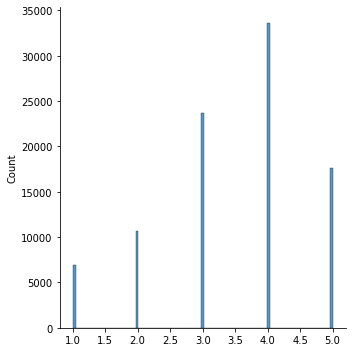

In [ ]:
sns.displot(df['rating'].tolist(),)

In [ ]:
for rating in df['rating']:
  if (int(rating) <= 3):
    labels.append(0)
  else :
    labels.append(1)
 

In [ ]:
train_labels = labels[:80000]
test_labels = labels[80000:]


In [ ]:
val_labels = train_labels[70000:]
train_labels = train_labels[:70000]

In [ ]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

In [ ]:
np.unique(train_labels)

array([0, 1])

In [ ]:
np.unique(test_labels)

array([0, 1])

In [ ]:
vocab_size = 10000
embedding_dim = 64
max_length = 1200

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")

In [ ]:
tokenizer.fit_on_texts(train_contents)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_contents)

In [ ]:
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, truncating='post', padding='post')

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_contents)
val_sequences = tokenizer.texts_to_sequences(val_contents)

In [ ]:
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, truncating='post', padding='post')
padded_val_sequences = pad_sequences(val_sequences, maxlen=max_length, truncating='post', padding='post')

In [ ]:
padded_val_sequences

array([[  24,   56,   13, ...,    0,    0,    0],
       [2718,  282,  106, ...,    0,    0,    0],
       [1481,   38,  128, ...,    0,    0,    0],
       ...,
       [ 173,  208, 1036, ...,    0,    0,    0],
       [ 173,  607, 1062, ...,    0,    0,    0],
       [  92, 1002,   10, ...,    0,    0,    0]], dtype=int32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

In [ ]:
model.add(Flatten())

In [ ]:
model.add(Dropout(0.8))

In [ ]:
model.add(Dense(32, activation='relu'))

In [ ]:
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1200, 64)          640000    
                                                                 
 flatten_3 (Flatten)         (None, 76800)             0         
                                                                 
 dropout_3 (Dropout)         (None, 76800)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                2457632   
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,097,698
Trainable params: 3,097,698
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils import np_utils
train_l = np_utils.to_categorical(train_labels,2)
test_l = np_utils.to_categorical(test_labels, 2)
val_l = np_utils.to_categorical(val_labels, 2)

In [ ]:
train_l

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [ ]:
model.fit(padded_train_sequences, train_l, epochs=10, validation_data=(padded_val_sequences, val_l), callbacks=[callback])

Epoch 1/10
2188/2188 [==============================] - 23s 10ms/step - loss: 0.5609 - acc: 0.7020 - val_loss: 0.4948 - val_acc: 0.7665
Epoch 2/10
2188/2188 [==============================] - 22s 10ms/step - loss: 0.4249 - acc: 0.8051 - val_loss: 0.4953 - val_acc: 0.7626
Epoch 3/10
2188/2188 [==============================] - 22s 10ms/step - loss: 0.3596 - acc: 0.8392 - val_loss: 0.4857 - val_acc: 0.7750
Epoch 4/10
2188/2188 [==============================] - 22s 10ms/step - loss: 0.3105 - acc: 0.8654 - val_loss: 0.5022 - val_acc: 0.7755
Epoch 5/10
2188/2188 [==============================] - 22s 10ms/step - loss: 0.2737 - acc: 0.8832 - val_loss: 0.5285 - val_acc: 0.7689
Epoch 6/10
2188/2188 [==============================] - 22s 10ms/step - loss: 0.2495 - acc: 0.8939 - val_loss: 0.5305 - val_acc: 0.7707
Epoch 7/10
2188/2188 [==============================] - 22s 10ms/step - loss: 0.2283 - acc: 0.9050 - val_loss: 0.5608 - val_acc: 0.7751
Epoch 8/10
2188/2188 [==========================

In [ ]:
padded_test_sequences

array([[ 664, 9113,  173, ...,    0,    0,    0],
       [2504,  221,  108, ...,    0,    0,    0],
       [ 538,   89,  135, ...,    0,    0,    0],
       ...,
       [  95,    6,  216, ...,    0,    0,    0],
       [  28,   51,  297, ...,    0,    0,    0],
       [  82,   33, 8926, ...,    0,    0,    0]], dtype=int32)

In [ ]:
test_predicted = model.predict(padded_test_sequences)

In [ ]:
test_predicted

array([[0.9923396 , 0.00766033],
       [0.12323847, 0.87676156],
       [0.851737  , 0.14826299],
       ...,
       [0.71023595, 0.28976408],
       [0.9734718 , 0.02652821],
       [0.0037    , 0.99630004]], dtype=float32)

In [ ]:
predicted_labels = []

In [ ]:

for result_one_hot_predicted in test_predicted:
  rating_predicted = np.argmax(result_one_hot_predicted)
  predicted_labels.append(rating_predicted)


In [ ]:
score = model.evaluate(padded_test_sequences, test_l,verbose=0)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, predicted_labels)
print('Confusion matrix:')
print(cnf_matrix)
print(type(cnf_matrix))

Confusion matrix:
[[4232 1341]
 [1353 5616]]
<class 'numpy.ndarray'>


In [ ]:
def cm2pr_binary(cm):
    p = cm[0,0]/np.sum(cm[:,0])
    r = cm[0,0]/np.sum(cm[0])
    return p, r
p,r = cm2pr_binary(cnf_matrix)
print("precition = {0:.2f}, recall = {1:.2f}".format(p, r))

precition = 0.76, recall = 0.76


In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

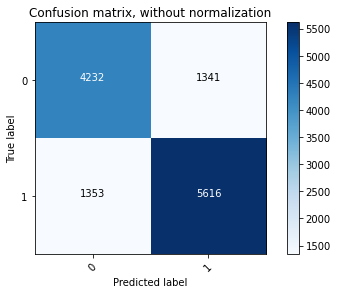

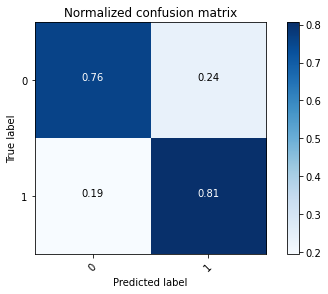

In [ ]:
# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
print(score)

[0.5258732438087463, 0.7852017283439636]


In [ ]:
embedding_layer = model.layers[0]

In [ ]:
weights = embedding_layer.get_weights()[0]

In [ ]:
import io

out_v = io.open('./drive/MyDrive/imdb_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./drive/MyDrive/imdb_meta.tsv', 'w', encoding='utf-8')

for idx in range(1, vocab_size):
  word = tokenizer.index_word[idx]
  vector = weights[idx]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(vi) for vi in vector]) + "\n")

out_m.close()
out_v.close()

In [ ]:
model_json = model.to_json()

In [ ]:
with open("./drive/MyDrive/imdb_model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
model.save_weights("./drive/MyDrive/model.h5")

In [ ]:
json_file = open('./drive/MyDrive/imdb_model.json', 'r')

In [ ]:
loaded_model_json = json_file.read()

In [ ]:
json_file.close()

In [ ]:
from keras.models import model_from_json
loaded_model = model_from_json(loaded_model_json)

In [ ]:
loaded_model.load_weights('./drive/MyDrive/model.h5')

In [ ]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1200, 64)          640000    
                                                                 
 flatten_3 (Flatten)         (None, 76800)             0         
                                                                 
 dropout_3 (Dropout)         (None, 76800)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                2457632   
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,097,698
Trainable params: 3,097,698
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_sen = ["I don't like movie because it's so terrible"]
test_sen = [text_preprocessing(doc) for doc in test_sen]
print(test_sen[0])
test_seq = tokenizer.texts_to_sequences(test_sen)
padded_test_seq = pad_sequences(test_seq, maxlen = max_length, truncating="post", padding="post")

do not like because so terrible


In [ ]:
model.predict(padded_test_seq)

array([[0.6626426, 0.3373574]], dtype=float32)

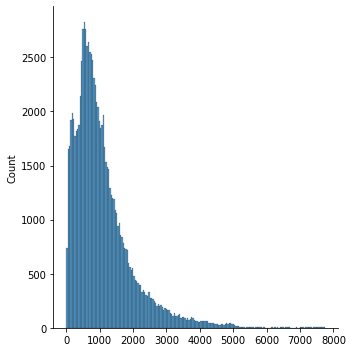

In [ ]:
content_len = [len(content) for content in contents]
sns.displot(content_len)

In [ ]:
FREQWORDS

{'a',
 'and',
 'as',
 'film',
 'for',
 'i',
 'imdb',
 'in',
 'is',
 'it',
 'movie',
 'of',
 'that',
 'the',
 'this',
 'to',
 'with'}